This LightGBM runs on Kaggle as well as on my 3-year old i5/8GB Surface laptop in less than 15 minutes to generate a submission. It has 19 features and produced LB 0.392 (22% when submitted earlier today). Part of it is similar to the many public kernels (such as Fabien Vavrand, Khaled Elshamouty, Paul-Antoine Nguyen, China, etc. These kernels have all in common a global single threshold of around 0.21 and they lead to F1 around 0.375 - 0.38 (perhaps corresponding to the peak in the distribution of LB score just at this level). What is different here is that this kernel runs on Kaggle in the allowed time of 20 minutes using 100% of the data. With a single threshold it also gives 0.38 but when this is relaxed and the calculation is repeated for several thresholds (e.g. 0.17, 0.21, 0.25) and then a second classifier is applied to train again on the "train" data to select the best F1 of the three thresholds for each order we get meaningful improvement to 0.386 and a jump of 130 places on LB. The new features for the second clf are the mean,max,min of the reorder probabilities for each of the three thresholds (chosen just for simplicity - std and len work too).  Next, browsing the discussions I realized that F1 can be further improved by stupidly adding 'None' to orders of one or two products. I did that and the LB score jumped again to 0.39 and finally I made it a bit smarter by adding this the extra 'None' only if the probability was less than 0.5 - and score went to 0.392.

I started this exercise before I had a chance to look at the theoretical papers on multi-label classification such as Nan Ye at al, Optimizing F-measures, 2012 and Z. Lipton et al, Thresholding classifiers, 2014. I entered this competition too late to dig into it deeper. I was initially puzzled by the fact that maximum F1 gives a much bigger cart size (about 8 products instead of 6) - see the chart below. Since the deadline is almost here I implemented at least this partial optimization of F1 with three separate thresholds and the extra 'None'. This F1 optimization added 0.011. Is more possible by further optimizing F1 or is the next jump due to more and better features or better parameters and more time training lgbm? I am not using here Faron's kernel nor any of Sh1ng's code.

This was my first real Kaggle competition and I have learned great deal doing it - thank you all.


![alt text](F1_vs_mean_cart_size.jpg "F1 vs Mean Cart Size")

In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

myfolder = '../input/'
print('loading files ...')

prior = pd.read_csv(myfolder + 'order_products__prior.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.uint8, 'add_to_cart_order': np.uint8})

train_orders = pd.read_csv(myfolder + 'order_products__train.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.int8, 'add_to_cart_order': np.uint8 })

orders = pd.read_csv(myfolder + 'orders.csv', dtype={'order_hour_of_day': np.uint8,
           'order_number': np.uint8, 'order_id': np.uint32, 'user_id': np.uint32,
           'order_dow': np.uint8, 'days_since_prior_order': np.float16})

orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.uint8)
orders.days_since_prior_order = orders.days_since_prior_order.fillna(30).astype(np.uint8)

products = pd.read_csv(myfolder + 'products.csv', dtype={'product_id': np.uint16,
            'aisle_id': np.uint8, 'department_id': np.uint8},
             usecols=['product_id', 'aisle_id', 'department_id'])

print('done loading')

loading files ...
done loading


In [2]:
print('merge prior and orders and keep train separate ...')

orders_products = orders.merge(prior, how = 'inner', on = 'order_id')
train_orders = train_orders.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')

del prior
gc.collect()

merge prior and orders and keep train separate ...


35

In [3]:
print('Creating features I ...')

# sort orders and products to get the rank or the reorder frequency
prdss = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prdss['product_time'] = prdss.groupby(['user_id', 'product_id']).cumcount()+1

# getting products ordered first and second times to calculate probability later
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

del sub1, sub2, prdss
gc.collect()

Creating features I ...


216

In [4]:
print('Creating features II ...')

# extracting prior information (features) by user
users = orders[orders['eval_set'] == 0].groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].mean()

# merging features about users and orders into one dataset
us = orders_products.groupby('user_id').size().to_frame('user_total_products')
us['eq_1'] = orders_products[orders_products['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_products[orders_products['order_number'] > 1].groupby('user_id')['product_id'].size()
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = orders_products.groupby(['user_id'])['product_id'].nunique()

# the average basket size of the user
users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

us = orders[orders['eval_set'] != 0]
us = us[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = users.merge(us)

del us
gc.collect()

Creating features II ...


172

In [5]:
print('Finalizing features and the main data file  ...')
# merging orders and products and grouping by user and product and calculating features for the user/product combination
data = orders_products.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merging previous data with users
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
data = data.merge(train_orders[['user_id', 'product_id', 'reordered']], 
                  how = 'left', on = ['user_id', 'product_id'])
data = data.merge(products, on = 'product_id')

del orders_products     #, orders, train_orders
gc.collect()

Finalizing features and the main data file  ...


63

In [6]:
print(' Training and test data for later use in F1 optimization and training  ...')

#save the actual reordered products of the train set in a list format and then delete the original frames
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders.set_index('order_id', drop=False, inplace=True)
train1=orders[['order_id','eval_set']].loc[orders['eval_set']==1]
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
train1['actual']=train1['actual'].fillna('')
n_actual = train1['actual'].apply(lambda x: len(x)).mean()   # this is the average cart size

test1=orders[['order_id','eval_set']].loc[orders['eval_set']==2]
test1['actual']=' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=False, inplace=True)

del orders, train_orders, train1, test1
gc.collect()

 Training and test data for later use in F1 optimization and training  ...


45

In [7]:
print('setting dtypes for data ...')

#reduce the size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, 'product_id'  : np.uint16,
            'up_orders'  : np.uint8, 'up_first_order' : np.uint8, 'up_last_order' : np.uint8,
            'up_average_cart_position' : np.uint8, 'prod_orders' : np.uint16, 
            'prod_reorder_probability' : np.float16,   
            'prod_reorder_ratio' : np.float16, 'user_orders' : np.uint8,
            'user_period' : np.uint8, 'user_mean_days_since_prior' : np.uint8,
            'user_total_products' : np.uint8, 'user_reorder_ratio' : np.float16, 
            'user_distinct_products' : np.uint8, 'user_average_basket' : np.uint8,
            'order_id'  : np.uint32, 'eval_set' : np.uint8, 
            'days_since_prior_order' : np.uint8, 'up_order_rate' : np.float16, 
            'up_orders_since_last_order':np.uint8,
            'aisle_id': np.uint8, 'department_id': np.uint8})

data['reordered'].fillna(0, inplace=True)  # replace NaN with zeros (not reordered) 
data['reordered']=data['reordered'].astype(np.uint8)

gc.collect()

setting dtypes for data ...


7

In [8]:
print('Preparing Train and Test sets ...')

# filter by eval_set (train=1, test=2) and dropp the id's columns (not part of training features) 
# but keep prod_id and user_id in test

train = data[data['eval_set'] == 1].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 2].drop(['eval_set', 'user_id', 'reordered'], axis = 1)

check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

del data
gc.collect()

Preparing Train and Test sets ...


7

In [9]:
print('preparing X,y for LightGBM ...')

X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=2)

del train
gc.collect()

preparing X,y for LightGBM ...


51

In [10]:
print('formatting and training LightGBM ...')

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

# there is some room to change the parameters and improve - I have not done it systematically

params = {'task': 'train', 'boosting_type': 'gbdt',   'objective': 'binary', 'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000, 'max_bin' : 100, 'num_leaves': 512, 'feature_fraction': 0.8,  'bagging_fraction': 0.95,
    'bagging_freq': 5, 'min_data_in_leaf' : 200, 'learning_rate' : 0.05}

# set lower num_boost_round (I used 300 instead of 50 at home) to avoid time-out on Kaggle

lgb_model = lgb.train(params, lgb_train, num_boost_round = 50, valid_sets = lgb_eval, early_stopping_rounds=10)

del lgb_train, X_train, y_train
gc.collect()


formatting and training LightGBM ...
[1]	valid_0's binary_logloss: 0.658635	valid_0's auc: 0.81528
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.627156	valid_0's auc: 0.825146
[3]	valid_0's binary_logloss: 0.598785	valid_0's auc: 0.824407
[4]	valid_0's binary_logloss: 0.572709	valid_0's auc: 0.826403
[5]	valid_0's binary_logloss: 0.548854	valid_0's auc: 0.827397
[6]	valid_0's binary_logloss: 0.527079	valid_0's auc: 0.827882
[7]	valid_0's binary_logloss: 0.507068	valid_0's auc: 0.828354
[8]	valid_0's binary_logloss: 0.488677	valid_0's auc: 0.828462
[9]	valid_0's binary_logloss: 0.471645	valid_0's auc: 0.828824
[10]	valid_0's binary_logloss: 0.455979	valid_0's auc: 0.828925
[11]	valid_0's binary_logloss: 0.441606	valid_0's auc: 0.82878
[12]	valid_0's binary_logloss: 0.428161	valid_0's auc: 0.828959
[13]	valid_0's binary_logloss: 0.415695	valid_0's auc: 0.829161
[14]	valid_0's binary_logloss: 0.404125	valid_0's auc: 0.82926
[15]	valid_0's bi

77

In [11]:
# Define an auxiliary function to combine the product data into orders

def combi(z,df):
    
    prd_bag = dict()
    z_bag = dict()
    for row in df.itertuples():
        if row.reordered > z:   
            try:
                prd_bag[row.order_id] += ' ' + str(row.product_id)
                z_bag[row.order_id]+= ' ' + str(int(100*row.reordered))
            except:
                prd_bag[row.order_id] = str(row.product_id)
                z_bag[row.order_id]= str(int(100*row.reordered))

    for order in df.order_id:
        if order not in prd_bag:
            prd_bag[order] = ' '
            z_bag[order] = ' '

    return prd_bag,z_bag 

# F1 function uses the actual products as a list in the train set and the list of predicted products

def f1_score_single(x):                 #from LiLi but modified to get 1 for both empty

    y_true = x.actual
    y_pred = x.list_prod
    if y_true == '' and y_pred ==[] : return 1.
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)

In [12]:
# check feature importance
#lgb.plot_importance(lgb_model, figsize=(7,9))
#plt.show()

In [13]:
print(' Applying model to all data - both train and test ')


check['reordered'] = lgb_model.predict(check[check.columns.difference(
    ['order_id', 'product_id'])], num_iteration = lgb_model.best_iteration)

gc.collect()

 Applying model to all data - both train and test 


29

The next step is to chose a threshold to select the reordered products. We know that a single global threshold of 0.21 maximizes F1 (given that the max is about 0.4 - see also the chart at the begining or end). The method here is to use several (eg 3 such as 0.17,0.21,0.25) thresholds and recalculate F1 on the training set. In addition to the products for each order we will collect the probabilities and store them in list and calculate the mean, max and min as our new features. Then we set up a new classification problem with the target [0,1, or 2] corresponding to which threshold maximizes F1. Alltogether we will use 9 features (we could easily generalize to more thresholds and features) .  This is relatively easy problem and we use Gradient Boosting Classifier with default parameters. 

In [14]:
print(' summarizing products and probabilities ...')

# get the prediction for a range of thresholds

tt=traintest1.copy()
i=0

for z in [0.17, 0.21, 0.25]:
    
    prd_bag,z_bag = combi(z,check)
    ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
    ptemp.reset_index(inplace=True)
    ztemp = pd.DataFrame.from_dict(z_bag, orient='index')
    ztemp.reset_index(inplace=True)
    ptemp.columns = ['order_id', 'products']
    ztemp.columns = ['order_id', 'zs']
    ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
    ztemp['list_z'] = ztemp['zs'].apply(lambda x: list(map(int, x.split())))
    n_cart = ptemp['products'].apply(lambda x: len(x.split())).mean()
    tt = tt.merge(ptemp,on='order_id',how='inner')
    tt = tt.merge(ztemp,on='order_id',how='inner')
    tt.drop(['products','zs'],axis=1,inplace=True)
    tt['zavg'] = tt['list_z'].apply(lambda x: 0.01*np.mean(x) if x!=[] else 0.).astype(np.float16)
    tt['zmax'] = tt['list_z'].apply(lambda x: 0.01*np.max(x) if x!=[] else 0.).astype(np.float16)
    tt['zmin'] = tt['list_z'].apply(lambda x: 0.01*np.min(x) if x!=[] else 0.).astype(np.float16)
    tt['f1']=tt.apply(f1_score_single,axis=1).astype(np.float16)
    F1 = tt['f1'].loc[tt['eval_set']==1].mean()
    tt = tt.rename(columns={'list_prod': 'prod'+str(i), 'f1': 'f1'+str(i), 'list_z': 'z'+str(i),
                'zavg': 'zavg'+str(i), 'zmax': 'zmax'+str(i),  'zmin': 'zmin'+str(i)})
    print(' z,F1,n_actual,n_cart :  ', z,F1,n_actual,n_cart)
    i=i+1

tt['fm'] = tt[['f10', 'f11', 'f12']].idxmax(axis=1)
tt['f1'] = tt[['f10', 'f11', 'f12']].max(axis=1)
tt['fm'] = tt.fm.replace({'f10': 0,'f11': 1, 'f12':2}).astype(np.uint8)
print(' f1 maximized ', tt['f1'].loc[tt['eval_set']==1].mean())
    
del prd_bag, z_bag, ptemp, ztemp
gc.collect()

 summarizing products and probabilities ...
 z,F1,n_actual,n_cart :   0.17 0.37109 6.316822778925226 13.086121362307173
 z,F1,n_actual,n_cart :   0.21 0.38013 6.316822778925226 9.68786037466842
 z,F1,n_actual,n_cart :   0.25 0.37891 6.316822778925226 7.4207478820032104
 f1 maximized  0.44019


111

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

print('Fitting the second classifier for F1 ...')

X=tt[[ 'zavg0', 'zmax0','zmin0', 'zavg1', 'zmax1', 'zmin1', 'zavg2', 'zmax2', 'zmin2']].loc[tt['eval_set']==1]
y=tt['fm'].loc[tt['eval_set']==1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = GradientBoostingClassifier().fit(X_train, y_train)
print('GB Accuracy on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}' .format(clf.score(X_test, y_test)))
#pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["Importance"]).plot(kind='bar')
#plt.show()

final=tt[['order_id','prod0','prod1','prod2','zavg0']].loc[tt['eval_set']==2]
df_test=tt[[ 'zavg0', 'zmax0','zmin0', 'zavg1', 'zmax1', 'zmin1', 'zavg2', 'zmax2', 'zmin2']].loc[tt['eval_set']==2]
final['fit']= clf.predict(df_test)
final['best'] = final.apply(lambda row: row['prod0'] if row['fit']==0 else 
                                 ( row['prod1'] if row['fit']==1 else  row['prod2'] )  , axis=1)

#final['products']=final['best'].apply(lambda x: ' '.join(str(i) for i in x) if x!=[] else 'None')

# I am adding 'None' to orders with one or two products because of the bias in F1

def mylist(x):
    prodids = x.best
    zavg = x.zavg0
    if prodids == []: return 'None'            
    if zavg < 0.5:
        if len(prodids) == 1: return  str(prodids[0])+' None'
        if len(prodids) == 2: return  str(prodids[0])+ ' '+ str(prodids[1]) +' None'
    return ' '.join(str(i) for i in prodids)

final['products']=final.apply(mylist,axis=1)

final[['order_id','products']].to_csv('final_submission1.csv', index=False)  

gc.collect()

Fitting the second classifier for F1 ...
GB Accuracy on training set: 0.57
Accuracy on test set: 0.57


14

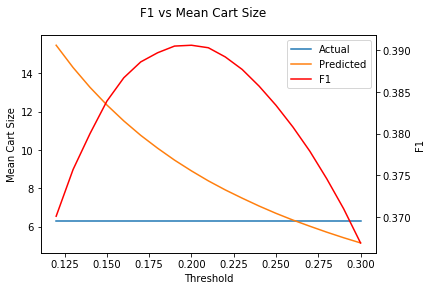

In [16]:
#I saved one of the previous runs so that it is not timed out on Kaggle
X=np.arange(0.12,0.31,0.01)
Y2 = np.empty(19)
Y2.fill(6.31)
Y1=[ 0.3701,0.3757,0.38,0.3839,0.3867,0.3886,0.3897,0.3905,0.3906,0.3903,
    0.3892,0.3877,0.3857,0.3834,0.3808,0.3779,0.3746,0.371,0.3669]
Y3=[ 15.45,14.29,13.26,12.34,11.51,10.76,10.09,9.47,8.91,8.39,7.92,7.49,
    7.08,6.7,6.35,6.03,5.72,5.43,5.16]
#replace X,Y1,Y2,Y3 with arrays from z,F1,n_actual,n_cart to update (running the above cell for the corresponding rane of z's)

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(X, Y2, '-', label = 'Actual')
lns2 = ax.plot(X, Y3, '-', label = 'Predicted')
ax2 = ax.twinx()
lns3 = ax2.plot(X, Y1, '-r', label = 'F1')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Cart Size')
ax2.set_ylabel('F1')
plt.suptitle('F1 vs Mean Cart Size', size=12)
plt.savefig('F1_vs_mean_cart_size.jpg')
plt.show()